In [ ]:
!pip install pandas numpy yfinance xgboost transformers matplotlib scikit-learn

In [ ]:
!pip install pandas numpy yfinance matplotlib scikit-learn textblob

SyntaxError: invalid syntax (<ipython-input-3-54d979571963>, line 9)

[*********************100%***********************]  1 of 1 completed

Running prediction model...


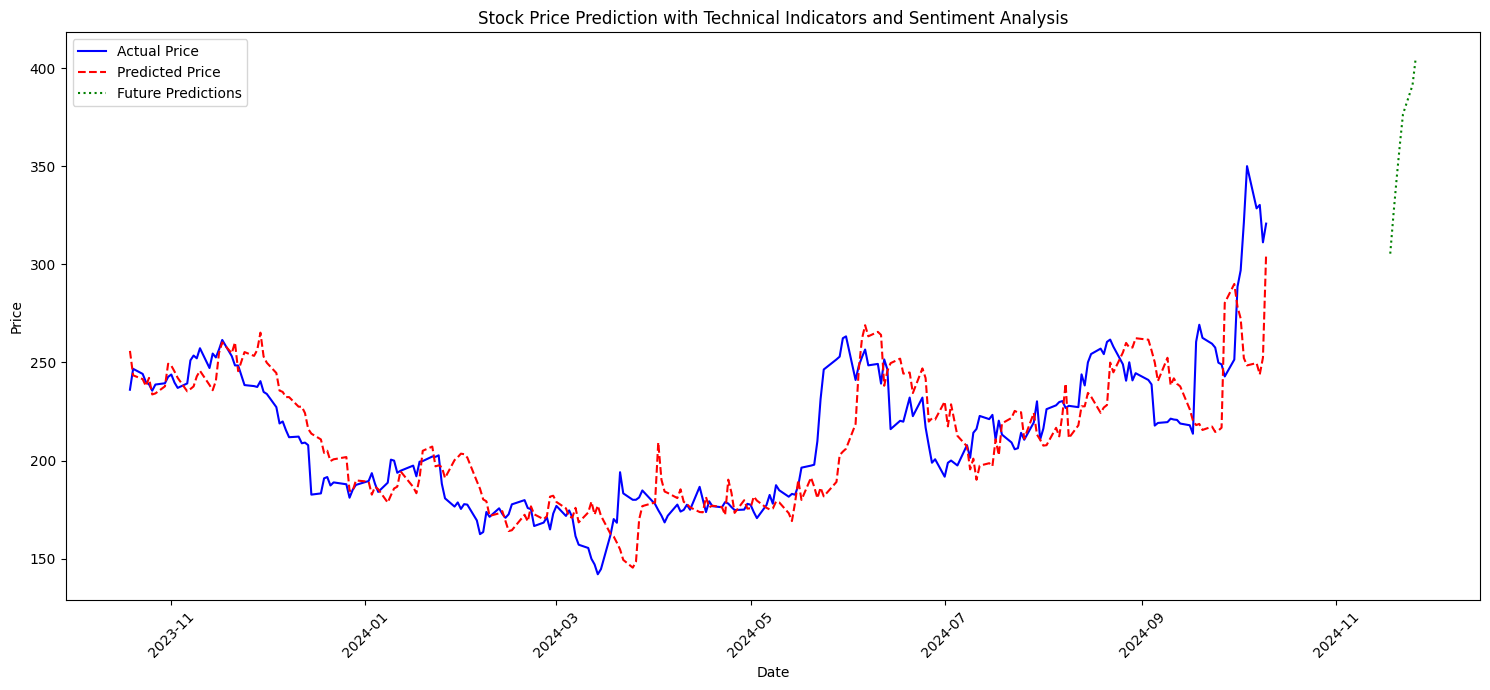


Model Performance Metrics:
RMSE: 22.34
R² Score: 0.6279

Future Price Predictions:
2024-11-18: 305.41
2024-11-19: 325.15
2024-11-20: 343.52
2024-11-21: 360.60
2024-11-22: 376.49
2024-11-25: 391.28
2024-11-26: 405.03


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import math

def ENHANCED_STOCK_PREDICTION(df, news_df=None, forecast_out=7, sentiment_weight=0.3):
    """
    Enhanced Linear Regression model for stock price prediction
    """

    # Create a copy and ensure single-level index
    df = df.copy()
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level=1, drop=True)

    # Reset index to make Date a column
    df = df.reset_index()

    # Ensure Date column is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Technical Indicators
    def calculate_technical_indicators(df):
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=5).std()

        # Momentum
        df['Momentum'] = df['Close'] - df['Close'].shift(4)

        return df

    # Add technical indicators
    df = calculate_technical_indicators(df)

    # Sentiment Analysis
    if news_df is not None:
        try:
            # Ensure news_df Date is datetime and reset index
            news_df = news_df.copy()
            news_df['Date'] = pd.to_datetime(news_df['Date'])

            # Calculate sentiment scores
            def get_sentiment_score(headlines):
                if isinstance(headlines, str):
                    return TextBlob(headlines).sentiment.polarity
                return 0

            # Calculate daily sentiment
            news_df['Sentiment'] = news_df['Headlines'].apply(get_sentiment_score)
            daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()

            # Merge sentiment with main DataFrame
            df = pd.merge(df, daily_sentiment, on='Date', how='left')
            df['Sentiment'] = df['Sentiment'].fillna(0)

        except Exception as e:
            print(f"Warning: Error in sentiment analysis: {str(e)}")
            df['Sentiment'] = 0
    else:
        df['Sentiment'] = 0

    # Feature Engineering
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Close_Ratio'] = df['Close'] / df['Open']
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=5).mean()

    # Target variable
    df['Target'] = df['Close'].shift(-forecast_out)

    # Feature selection
    feature_columns = [
        'Close', 'Volume_Ratio', 'Close_Ratio', 'High_Low_Ratio',
        'MA5', 'MA20', 'RSI', 'MACD', 'Volatility', 'Momentum',
        'Sentiment', 'DayOfWeek', 'Month'
    ]

    # Prepare data
    X = df[feature_columns].dropna()
    y = df['Target'].dropna()

    # Align X and y
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Split data
    train_size = int(0.8 * len(X))
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate error metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predict future values
    last_data = X.iloc[-1:].copy()
    future_dates = pd.date_range(start=df['Date'].iloc[-1] + timedelta(days=1),
                               periods=forecast_out, freq='B')
    future_predictions = []

    for _ in range(forecast_out):
        scaled_data = scaler.transform(last_data)
        pred = model.predict(scaled_data)[0]
        future_predictions.append(pred)

        # Update last_data for next prediction
        last_data['Close'] = pred
        last_data['MA5'] = pred
        last_data['MA20'] = pred

    # Plotting
    plt.figure(figsize=(15, 7))

    # Plot training data
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_test, label='Actual Price', color='blue')
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_pred, label='Predicted Price', color='red', linestyle='--')

    # Plot future predictions
    plt.plot(future_dates, future_predictions,
             label='Future Predictions', color='green', linestyle=':')

    plt.title('Stock Price Prediction with Technical Indicators and Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'test_predictions': y_pred,
        'future_predictions': future_predictions,
        'future_dates': future_dates,
        'rmse': rmse,
        'r2': r2,
        'model': model,
        'scaler': scaler
    }

# Run the prediction
ticker = "TSLA"
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading data for {ticker} from {start_date.date()} to  {end_date.date()}...")
df = yf.download(ticker, start=start_date, end=end_date)

# Create sample news data
dates = pd.date_range(start=start_date, end=end_date, freq='B')
sample_headlines = [
    "Positive news about " + ticker,
    "Negative news about " + ticker,
    "Neutral news about " + ticker
] * (len(dates) // 3 + 1)

news_df = pd.DataFrame({
    'Date': dates[:len(sample_headlines)],
    'Headlines': sample_headlines[:len(dates)]
})

print("Running prediction model...")
try:
    results = ENHANCED_STOCK_PREDICTION(
        df=df,
        news_df=news_df,
        forecast_out=7,
        sentiment_weight=0.3
    )

    print("\nModel Performance Metrics:")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"R² Score: {results['r2']:.4f}")

    print("\nFuture Price Predictions:")
    for date, pred in zip(results['future_dates'], results['future_predictions']):
        print(f"{date.date()}: {pred:.2f}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

[*********************100%***********************]  1 of 1 completed

Running prediction model...


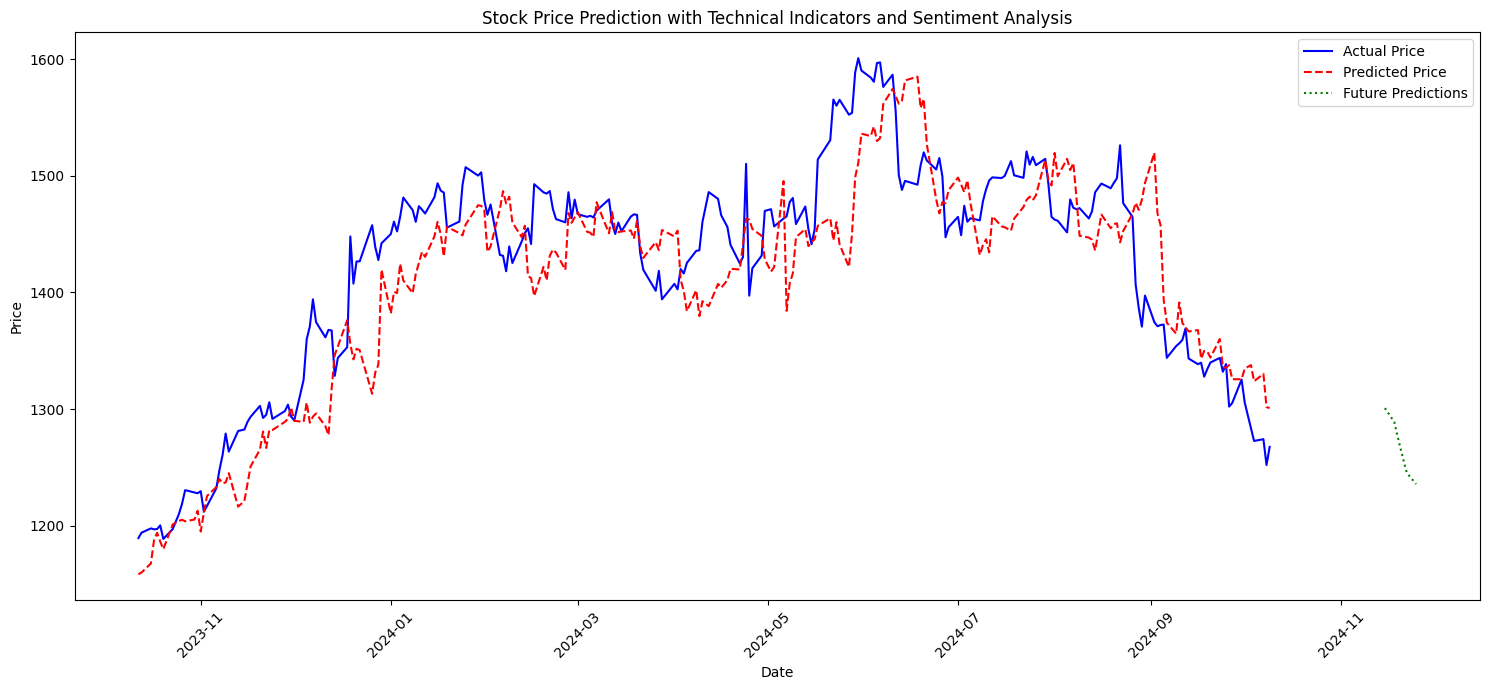


Model Performance Metrics:
RMSE: 49.03
R² Score: 0.7349

Future Price Predictions:
2024-11-15: 1300.92
2024-11-18: 1288.88
2024-11-19: 1277.34
2024-11-20: 1266.27
2024-11-21: 1255.66
2024-11-22: 1245.49
2024-11-25: 1235.74


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import math

def ENHANCED_STOCK_PREDICTION(df, news_df=None, forecast_out=7, sentiment_weight=0.3):
    """
    Enhanced Linear Regression model for stock price prediction
    """

    # Create a copy and ensure single-level index
    df = df.copy()
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level=1, drop=True)

    # Reset index to make Date a column
    df = df.reset_index()

    # Ensure Date column is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Technical Indicators
    def calculate_technical_indicators(df):
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=5).std()

        # Momentum
        df['Momentum'] = df['Close'] - df['Close'].shift(4)

        return df

    # Add technical indicators
    df = calculate_technical_indicators(df)

    # Sentiment Analysis
    if news_df is not None:
        try:
            # Ensure news_df Date is datetime and reset index
            news_df = news_df.copy()
            news_df['Date'] = pd.to_datetime(news_df['Date'])

            # Calculate sentiment scores
            def get_sentiment_score(headlines):
                if isinstance(headlines, str):
                    return TextBlob(headlines).sentiment.polarity
                return 0

            # Calculate daily sentiment
            news_df['Sentiment'] = news_df['Headlines'].apply(get_sentiment_score)
            daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()

            # Merge sentiment with main DataFrame
            df = pd.merge(df, daily_sentiment, on='Date', how='left')
            df['Sentiment'] = df['Sentiment'].fillna(0)

        except Exception as e:
            print(f"Warning: Error in sentiment analysis: {str(e)}")
            df['Sentiment'] = 0
    else:
        df['Sentiment'] = 0

    # Feature Engineering
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Close_Ratio'] = df['Close'] / df['Open']
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=5).mean()

    # Target variable
    df['Target'] = df['Close'].shift(-forecast_out)

    # Feature selection
    feature_columns = [
        'Close', 'Volume_Ratio', 'Close_Ratio', 'High_Low_Ratio',
        'MA5', 'MA20', 'RSI', 'MACD', 'Volatility', 'Momentum',
        'Sentiment', 'DayOfWeek', 'Month'
    ]

    # Prepare data
    X = df[feature_columns].dropna()
    y = df['Target'].dropna()

    # Align X and y
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Split data
    train_size = int(0.8 * len(X))
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate error metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predict future values
    last_data = X.iloc[-1:].copy()
    future_dates = pd.date_range(start=df['Date'].iloc[-1] + timedelta(days=1),
                               periods=forecast_out, freq='B')
    future_predictions = []

    for _ in range(forecast_out):
        scaled_data = scaler.transform(last_data)
        pred = model.predict(scaled_data)[0]
        future_predictions.append(pred)

        # Update last_data for next prediction
        last_data['Close'] = pred
        last_data['MA5'] = pred
        last_data['MA20'] = pred

    # Plotting
    plt.figure(figsize=(15, 7))

    # Plot training data
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_test, label='Actual Price', color='blue')
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_pred, label='Predicted Price', color='red', linestyle='--')

    # Plot future predictions
    plt.plot(future_dates, future_predictions,
             label='Future Predictions', color='green', linestyle=':')

    plt.title('Stock Price Prediction with Technical Indicators and Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'test_predictions': y_pred,
        'future_predictions': future_predictions,
        'future_dates': future_dates,
        'rmse': rmse,
        'r2': r2,
        'model': model,
        'scaler': scaler
    }

# Run the prediction
ticker = "RELIANCE.NS"
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading data for {ticker} from {start_date.date()} to  {end_date.date()}...")
df = yf.download(ticker, start=start_date, end=end_date)

# Create sample news data
dates = pd.date_range(start=start_date, end=end_date, freq='B')
sample_headlines = [
    "Positive news about " + ticker,
    "Negative news about " + ticker,
    "Neutral news about " + ticker
] * (len(dates) // 3 + 1)

news_df = pd.DataFrame({
    'Date': dates[:len(sample_headlines)],
    'Headlines': sample_headlines[:len(dates)]
})

print("Running prediction model...")
try:
    results = ENHANCED_STOCK_PREDICTION(
        df=df,
        news_df=news_df,
        forecast_out=7,
        sentiment_weight=0.3
    )

    print("\nModel Performance Metrics:")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"R² Score: {results['r2']:.4f}")

    print("\nFuture Price Predictions:")
    for date, pred in zip(results['future_dates'], results['future_predictions']):
        print(f"{date.date()}: {pred:.2f}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

[*********************100%***********************]  1 of 1 completed


Running prediction model...


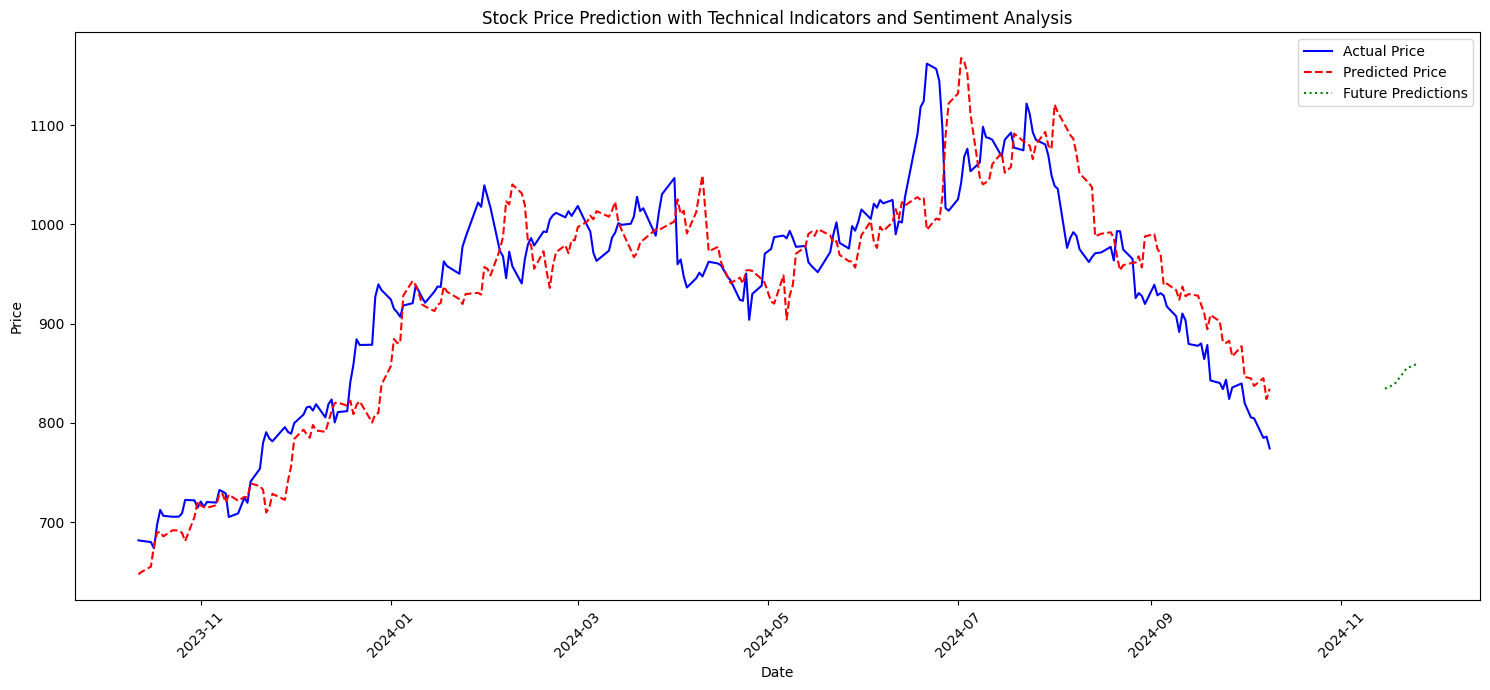


Model Performance Metrics:
RMSE: 49.24
R² Score: 0.8010

Future Price Predictions:
2024-11-15: 834.50
2024-11-18: 838.66
2024-11-19: 842.80
2024-11-20: 846.90
2024-11-21: 850.97
2024-11-22: 855.01
2024-11-25: 859.02


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import math

def ENHANCED_STOCK_PREDICTION(df, news_df=None, forecast_out=7, sentiment_weight=0.3):
    """
    Enhanced Linear Regression model for stock price prediction
    """

    # Create a copy and ensure single-level index
    df = df.copy()
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level=1, drop=True)

    # Reset index to make Date a column
    df = df.reset_index()

    # Ensure Date column is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Technical Indicators
    def calculate_technical_indicators(df):
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=5).std()

        # Momentum
        df['Momentum'] = df['Close'] - df['Close'].shift(4)

        return df

    # Add technical indicators
    df = calculate_technical_indicators(df)

    # Sentiment Analysis
    if news_df is not None:
        try:
            # Ensure news_df Date is datetime and reset index
            news_df = news_df.copy()
            news_df['Date'] = pd.to_datetime(news_df['Date'])

            # Calculate sentiment scores
            def get_sentiment_score(headlines):
                if isinstance(headlines, str):
                    return TextBlob(headlines).sentiment.polarity
                return 0

            # Calculate daily sentiment
            news_df['Sentiment'] = news_df['Headlines'].apply(get_sentiment_score)
            daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()

            # Merge sentiment with main DataFrame
            df = pd.merge(df, daily_sentiment, on='Date', how='left')
            df['Sentiment'] = df['Sentiment'].fillna(0)

        except Exception as e:
            print(f"Warning: Error in sentiment analysis: {str(e)}")
            df['Sentiment'] = 0
    else:
        df['Sentiment'] = 0

    # Feature Engineering
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Close_Ratio'] = df['Close'] / df['Open']
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=5).mean()

    # Target variable
    df['Target'] = df['Close'].shift(-forecast_out)

    # Feature selection
    feature_columns = [
        'Close', 'Volume_Ratio', 'Close_Ratio', 'High_Low_Ratio',
        'MA5', 'MA20', 'RSI', 'MACD', 'Volatility', 'Momentum',
        'Sentiment', 'DayOfWeek', 'Month'
    ]

    # Prepare data
    X = df[feature_columns].dropna()
    y = df['Target'].dropna()

    # Align X and y
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Split data
    train_size = int(0.8 * len(X))
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate error metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predict future values
    last_data = X.iloc[-1:].copy()
    future_dates = pd.date_range(start=df['Date'].iloc[-1] + timedelta(days=1),
                               periods=forecast_out, freq='B')
    future_predictions = []

    for _ in range(forecast_out):
        scaled_data = scaler.transform(last_data)
        pred = model.predict(scaled_data)[0]
        future_predictions.append(pred)

        # Update last_data for next prediction
        last_data['Close'] = pred
        last_data['MA5'] = pred
        last_data['MA20'] = pred

    # Plotting
    plt.figure(figsize=(15, 7))

    # Plot training data
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_test, label='Actual Price', color='blue')
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_pred, label='Predicted Price', color='red', linestyle='--')

    # Plot future predictions
    plt.plot(future_dates, future_predictions,
             label='Future Predictions', color='green', linestyle=':')

    plt.title('Stock Price Prediction with Technical Indicators and Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'test_predictions': y_pred,
        'future_predictions': future_predictions,
        'future_dates': future_dates,
        'rmse': rmse,
        'r2': r2,
        'model': model,
        'scaler': scaler
    }

# Run the prediction
ticker = "TATAMOTORS.NS"
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading data for {ticker} from {start_date.date()} to  {end_date.date()}...")
df = yf.download(ticker, start=start_date, end=end_date)

# Create sample news data
dates = pd.date_range(start=start_date, end=end_date, freq='B')
sample_headlines = [
    "Positive news about " + ticker,
    "Negative news about " + ticker,
    "Neutral news about " + ticker
] * (len(dates) // 3 + 1)

news_df = pd.DataFrame({
    'Date': dates[:len(sample_headlines)],
    'Headlines': sample_headlines[:len(dates)]
})

print("Running prediction model...")
try:
    results = ENHANCED_STOCK_PREDICTION(
        df=df,
        news_df=news_df,
        forecast_out=7,
        sentiment_weight=0.3
    )

    print("\nModel Performance Metrics:")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"R² Score: {results['r2']:.4f}")

    print("\nFuture Price Predictions:")
    for date, pred in zip(results['future_dates'], results['future_predictions']):
        print(f"{date.date()}: {pred:.2f}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

[*********************100%***********************]  1 of 1 completed


Running prediction model...


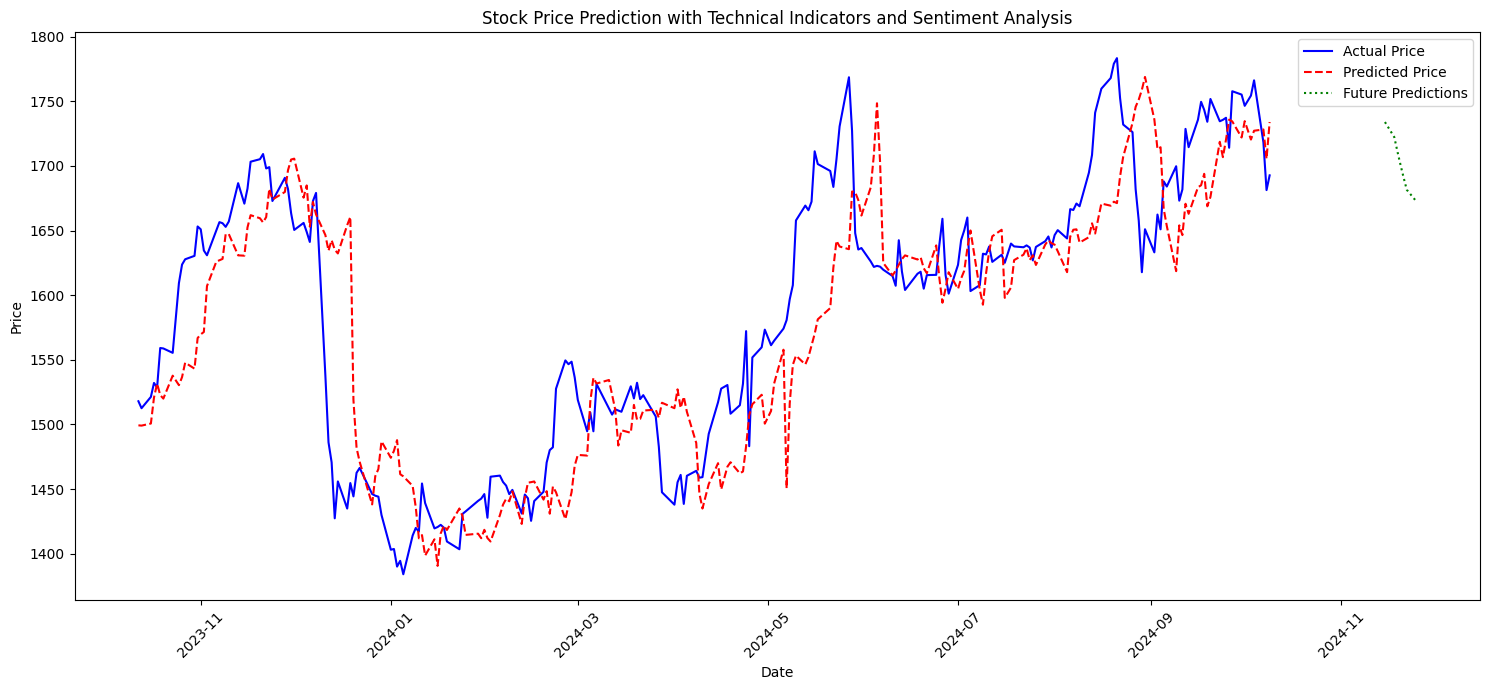


Model Performance Metrics:
RMSE: 60.04
R² Score: 0.6785

Future Price Predictions:
2024-11-15: 1734.01
2024-11-18: 1722.30
2024-11-19: 1711.24
2024-11-20: 1700.79
2024-11-21: 1690.93
2024-11-22: 1681.61
2024-11-25: 1672.81


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import math

def ENHANCED_STOCK_PREDICTION(df, news_df=None, forecast_out=7, sentiment_weight=0.3):
    """
    Enhanced Linear Regression model for stock price prediction
    """

    # Create a copy and ensure single-level index
    df = df.copy()
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index(level=1, drop=True)

    # Reset index to make Date a column
    df = df.reset_index()

    # Ensure Date column is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Technical Indicators
    def calculate_technical_indicators(df):
        df['MA5'] = df['Close'].rolling(window=5).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=5).std()

        # Momentum
        df['Momentum'] = df['Close'] - df['Close'].shift(4)

        return df

    # Add technical indicators
    df = calculate_technical_indicators(df)

    # Sentiment Analysis
    if news_df is not None:
        try:
            # Ensure news_df Date is datetime and reset index
            news_df = news_df.copy()
            news_df['Date'] = pd.to_datetime(news_df['Date'])

            # Calculate sentiment scores
            def get_sentiment_score(headlines):
                if isinstance(headlines, str):
                    return TextBlob(headlines).sentiment.polarity
                return 0

            # Calculate daily sentiment
            news_df['Sentiment'] = news_df['Headlines'].apply(get_sentiment_score)
            daily_sentiment = news_df.groupby('Date')['Sentiment'].mean().reset_index()

            # Merge sentiment with main DataFrame
            df = pd.merge(df, daily_sentiment, on='Date', how='left')
            df['Sentiment'] = df['Sentiment'].fillna(0)

        except Exception as e:
            print(f"Warning: Error in sentiment analysis: {str(e)}")
            df['Sentiment'] = 0
    else:
        df['Sentiment'] = 0

    # Feature Engineering
    df['Day'] = (df['Date'] - df['Date'].min()).dt.days
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Close_Ratio'] = df['Close'] / df['Open']
    df['High_Low_Ratio'] = df['High'] / df['Low']
    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=5).mean()

    # Target variable
    df['Target'] = df['Close'].shift(-forecast_out)

    # Feature selection
    feature_columns = [
        'Close', 'Volume_Ratio', 'Close_Ratio', 'High_Low_Ratio',
        'MA5', 'MA20', 'RSI', 'MACD', 'Volatility', 'Momentum',
        'Sentiment', 'DayOfWeek', 'Month'
    ]

    # Prepare data
    X = df[feature_columns].dropna()
    y = df['Target'].dropna()

    # Align X and y
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    # Split data
    train_size = int(0.8 * len(X))
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate error metrics
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Predict future values
    last_data = X.iloc[-1:].copy()
    future_dates = pd.date_range(start=df['Date'].iloc[-1] + timedelta(days=1),
                               periods=forecast_out, freq='B')
    future_predictions = []

    for _ in range(forecast_out):
        scaled_data = scaler.transform(last_data)
        pred = model.predict(scaled_data)[0]
        future_predictions.append(pred)

        # Update last_data for next prediction
        last_data['Close'] = pred
        last_data['MA5'] = pred
        last_data['MA20'] = pred

    # Plotting
    plt.figure(figsize=(15, 7))

    # Plot training data
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_test, label='Actual Price', color='blue')
    plt.plot(df['Date'].iloc[train_size:len(y_test)+train_size],
             y_pred, label='Predicted Price', color='red', linestyle='--')

    # Plot future predictions
    plt.plot(future_dates, future_predictions,
             label='Future Predictions', color='green', linestyle=':')

    plt.title('Stock Price Prediction with Technical Indicators and Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        'test_predictions': y_pred,
        'future_predictions': future_predictions,
        'future_dates': future_dates,
        'rmse': rmse,
        'r2': r2,
        'model': model,
        'scaler': scaler
    }

# Run the prediction
ticker = "HDFCBANK.NS"
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Downloading data for {ticker} from {start_date.date()} to  {end_date.date()}...")
df = yf.download(ticker, start=start_date, end=end_date)

# Create sample news data
dates = pd.date_range(start=start_date, end=end_date, freq='B')
sample_headlines = [
    "Positive news about " + ticker,
    "Negative news about " + ticker,
    "Neutral news about " + ticker
] * (len(dates) // 3 + 1)

news_df = pd.DataFrame({
    'Date': dates[:len(sample_headlines)],
    'Headlines': sample_headlines[:len(dates)]
})

print("Running prediction model...")
try:
    results = ENHANCED_STOCK_PREDICTION(
        df=df,
        news_df=news_df,
        forecast_out=7,
        sentiment_weight=0.3
    )

    print("\nModel Performance Metrics:")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"R² Score: {results['r2']:.4f}")

    print("\nFuture Price Predictions:")
    for date, pred in zip(results['future_dates'], results['future_predictions']):
        print(f"{date.date()}: {pred:.2f}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())